In [1]:
from google.colab import drive 

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/My Drive/master thesis/code/Learning-Shapelets"

/content/drive/My Drive/master thesis/code/Learning-Shapelets


In [3]:
#! pip install --user tslearn matplotlib

import os
## TODO change to 0
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

import sys
sys.path.append('/content/gdrive/My Drive/master thesis/code/Learning-Shapelets')

import random
import numpy
import numpy as np
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
!pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
import torch
from torch import nn, optim

from src.learning_shapelets import LearningShapelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.2/358.2 KB 17.4 MB/s eta 0:00:00


### Import Learning_Shapelets demo datasets

### Import UCR-Archive datasets

In [4]:
train_data = np.loadtxt("./demo/data/GunPoint_TRAIN", delimiter=',')
test_data = np.loadtxt("./demo/data/GunPoint_TEST", delimiter=',')


#train_data
X_train = np.expand_dims(train_data[:, 1:],axis=1)
X_train_size = X_train.shape[0]
print(X_train_size)
y_train = train_data[:, 0]-1
print(y_train.shape)

#test_data
X_test = np.expand_dims(test_data[:, 1:],axis=1)
X_test_size = X_test.shape[0]
y_test = test_data[:, 0]-1
print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_test: {X_test.shape}")

50
(50,)
Shape X_train: (50, 1, 150)
Shape X_test: (150, 1, 150)


### Run model

In [46]:
def normalize_standard(X, scaler=None):
    shape = X.shape
    data_flat = X.flatten()
    if scaler is None:
        scaler = StandardScaler()
        data_transformed = scaler.fit_transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    else:
        data_transformed = scaler.transform(data_flat.reshape(numpy.product(shape), 1)).reshape(shape)
    return data_transformed, scaler

def normalize_data(X, scaler=None):
    if scaler is None:
        X, scaler = normalize_standard(X)
    else:
        X, scaler = normalize_standard(X, scaler)
    
    return X, scaler

def sample_ts_segments(X, shapelets_size, n_segments=10000):
    """
    Sample time series segments for k-Means.
    """
    n_ts, n_channels, len_ts = X.shape
    samples_i = random.choices(range(n_ts), k=n_segments)
    segments = numpy.empty((n_segments, n_channels, shapelets_size))
    for i, k in enumerate(samples_i):
        s = random.randint(0, len_ts - shapelets_size)
        segments[i] = X[k, :, s:s+shapelets_size]
    return segments

def get_weights_via_kmeans(X, shapelets_size, num_shapelets, n_segments=10000):
    """
    Get weights via k-Means for a block of shapelets.
    """
    segments = sample_ts_segments(X, shapelets_size, n_segments).transpose(0, 2, 1)
    k_means = TimeSeriesKMeans(n_clusters=num_shapelets, metric="euclidean", max_iter=50).fit(segments)
    clusters = k_means.cluster_centers_.transpose(0, 2, 1)
    return clusters


# normalize training data
X_train, scaler = normalize_data(X_train)

n_ts, n_channels, len_ts = X_train.shape
loss_func = nn.CrossEntropyLoss()
num_classes = len(set(y_train))
# learn 48 shapelets
shapelets_size_and_len = {30:10,60:5 }
dist_measure = 'euclidean' #'cosine' #"euclidean"
lr = 4e-3
wd = 1e-4
epsilon = 1e-7
batch_size = 256
shuffle = True
drop_last = False


shapelets_blocks = []
for i, (shapelets_size, num_shapelets) in enumerate(shapelets_size_and_len.items()):
    weights_block = get_weights_via_kmeans(X_train, shapelets_size, num_shapelets)
    shapelets_blocks.append(weights_block)
    
"""
#old:
l1 = 0.05
l2 = 0.15
"""
l1 = 0.1
l2 = 0.01

k = int(0.1 * batch_size) if batch_size <= X_train_size else X_train_size


learning_shapelets_Lr = LearningShapelets(shapelets_size_and_len=shapelets_size_and_len,
                                       in_channels=n_channels,
                                       num_classes=num_classes,
                                       loss_func=loss_func,
                                       to_cuda=False,
                                       verbose=1,
                                       dist_measure=dist_measure,
                                       l1=l1,
                                       l2=l2,
                                       k=k)

for i, shapelets_block in enumerate(shapelets_blocks):
    learning_shapelets_Lr.set_shapelet_weights_of_block(i, shapelets_block)
    
optimizer = optim.Adam(learning_shapelets_Lr.model.parameters(), lr=lr, eps=epsilon)
learning_shapelets_Lr.set_optimizer(optimizer)

def eval_accuracy(model, X, Y):
    predictions = model.predict(X)
    if len(predictions.shape) == 2:
        predictions = predictions.argmax(axis=1)
        
        print(predictions)
    print(f"Accuracy: {(predictions == Y).sum() / Y.size}")
    return (predictions == Y).sum() / Y.size

epochs = 200
n_epoch_steps =5
losses = []
train_acc_last = 0

losses_acc = []
losses_dist = []
losses_sim = []
train_acc_last_Lr = 0
for _ in range(n_epoch_steps):
    losses_acc_i, losses_dist_i, losses_sim_i = \
        learning_shapelets_Lr.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=drop_last)
    losses_acc += losses_acc_i

    losses_dist += losses_dist_i
    losses_sim += losses_sim_i
    train_acc_current_Lr = eval_accuracy(learning_shapelets_Lr, X_train, y_train)
    if train_acc_current_Lr - train_acc_last_Lr < 1e-3 or train_acc_current_Lr == 1.0:
        break
    train_acc_last_Lr = train_acc_current_Lr

# normalize data
X_test, scaler = normalize_data(X_test, scaler)
test_acc = eval_accuracy(learning_shapelets_Lr, X_test, y_test)
print(test_acc)

Loss CE: 0.1416536569595337, Loss dist: 0.2142297476530075, Loss sim: 0.002002812223508954: 100%|██████████| 200/200 [00:04<00:00, 49.76it/s]


[1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1
 1 1 1 1 0 0 0 1 1 0 1 0 1]
Accuracy: 1.0
[0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1
 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1
 1 0]
Accuracy: 0.9733333333333334
0.9733333333333334


In [6]:
def filterNanFromShapelet(shapelet):
    """
    Filter NaN values from a shapelet.
    Needed for the output of learning shapelets from tslearn, since smaller size shapelets are padded with NaN values.
    Note: Make sure the NaN values are only leading or trailing.
    """
    return shapelet[~numpy.isnan(shapelet)]

def lead_pad_shapelet(shapelet, pos):
    """
    Adding leading NaN values to shapelet to plot it on a time series at the best matching position.
    """
    pad = numpy.empty(pos)
    pad[:] = numpy.NaN
    padded_shapelet = numpy.concatenate([pad, filterNanFromShapelet(shapelet)])
    return padded_shapelet

def torch_dist_ts_shapelet(ts, shapelet, to_cuda=True):
    """
    Use PyTorch to calculate the distance between a shapelet and a time series.
    Implemented via unfolding.
    """
    if not isinstance(ts, torch.Tensor):
        ts = torch.tensor(ts, dtype=torch.float)
    if not isinstance(shapelet, torch.Tensor):
        shapelet = torch.tensor(shapelet, dtype=torch.float)
    if to_cuda:
        ts = ts.cuda()
        shapelet = shapelet.cuda()
    if shapelet.dim() == 1:
        shapelet = torch.unsqueeze(shapelet, 0)
    # unfold time series to emulate sliding window
    ts = ts.unfold(1, shapelet.shape[1], 1)
    # calculate euclidean distance over each segment
    dists = torch.sum(torch.cdist(ts, shapelet, p=2), dim=0)
    # filter min dist
    d_min, d_argmin = torch.min(dists, 0)
    return (d_min.item(), d_argmin.item())

def dists_to_shapelet(data, shapelet, to_cuda=True):
    """
    Calculate the distances of a shapelet to a bunch of time series.
    """
    shapelet = filterNanFromShapelet(shapelet)
    dists = []
    for i in range(len(data)):
        dists.append((torch_dist_ts_shapelet(data[i,:], shapelet, to_cuda=to_cuda), i))
    return sorted(dists, key=lambda x: x[0][0])



def plot_shapelet_on_ts_at_i(shapelet, ts, i, title="", axis=None):
    """
    Plot a shapelet on top of a timeseries
    """
    shapelet = filterNanFromShapelet(shapelet)
    padded_shapelet = lead_pad_shapelet(shapelet, i)
    if axis is None:
        pyplot.clf()
        pyplot.rcParams["figure.figsize"] = (23, 6)
        pyplot.plot(ts)
        pyplot.plot(padded_shapelet)
    else:
        axis.plot(ts)
        axis.plot(padded_shapelet)
        
#CUSTOM:

def dists_ts_to_shapelets(ts, shapelets, to_cuda=False):
    """
    Calculate the distances of shapelets to a timeseries
    """
    dists = []
    for i in range(len(shapelets)):
        shapelet = filterNanFromShapelet(shapelets[i])
        dists.append((torch_dist_ts_shapelet(ts, shapelet, to_cuda=to_cuda),i))
    return sorted(dists, key=lambda x: x[0][0])

def plot_ts_and_shapelet(ts,shapelet): 
    sh = filterNanFromShapelet(shapelet)
    dist, pos = torch_dist_ts_shapelet(ts,sh,to_cuda=False)
    padded_shapelet = lead_pad_shapelet(sh,pos)
    pyplot.plot(ts.flatten())
    pyplot.plot(padded_shapelet)
    pyplot.show()

In [7]:
dist_data = learning_shapelets_Lr.transform(X_train[:3])
print(dist_data)

[[1.0475994  1.5309522  1.9730082  0.8387666  0.3401635  2.7600503
  4.615879   1.031091   1.164382   0.9750183  2.9142823  3.0702963
  3.2567258  3.256031   2.559012  ]
 [1.1801518  1.4765419  2.1198132  0.9297285  0.18576005 3.0850577
  4.730261   0.8905629  1.2768987  0.82650656 3.0731788  3.3072848
  3.4654064  3.4665794  2.7348847 ]
 [0.32818604 1.6754454  2.0548532  1.2176588  0.40965605 2.0809455
  4.1425934  0.49399972 0.8661267  1.4740233  2.216567   2.249934
  2.6885707  2.771858   1.6594001 ]]


In [ ]:
!pip install shap
import shap
dist_data = learning_shapelets_Lr.transform(X_train[:3])

def fu(x):
    helper_arr = []
    for i in x:
        sformat = torch.tensor((np.expand_dims(i,axis=0)), dtype=torch.float).cuda()
        helper_arr.append(learning_shapelets_Lr.model.linear(sformat).detach().cpu().numpy())
    return np.array(helper_arr)

print(fu(dist_data).squeeze().shape)

explainer = shap.KernelExplainer(fu,dist_data,link='logit')#,algorithm='permutation')
shap_values = explainer(dist_data)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 38.2 MB/s eta 0:00:00
(3, 2)


AttributeError: ignored

In [ ]:
masker = shap.maskers.Independent(dist_data, 10)

masker.data

array([[3.5726793, 2.5326889, 2.6843379, 4.42346  , 2.8938842],
       [3.3961806, 2.7724442, 2.6022236, 4.5172935, 3.1436687],
       [3.861206 , 1.9229485, 2.7808378, 3.9413621, 2.3463707]],
      dtype=float32)

In [ ]:
def fu(x):
    helper_arr = []
    for i in x:
        sformat = torch.tensor((np.expand_dims(i,axis=0)), dtype=torch.float).cuda()
        helper_arr.append(learning_shapelets_Lr.model.linear(sformat).detach().cpu().numpy())
    return np.array(helper_arr).squeeze()

print(fu(dist_data).shape)
#.squeeze().shape)



explainer = shap.KernelExplainer(fu,masker.data,link='logit')#,algorithm='permutation')
shap_values = explainer(dist_data)


(3, 2)


AttributeError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Flatten, Concatenate, concatenate, Dropout, Lambda
from keras.models import Model
from tensorflow.keras.layers import Embedding
from tqdm import tqdm
import shap

# print the JS visualization code to the notebook
shap.initjs()

array([False,  True, False, ..., False,  True, False])

In [ ]:
# build model
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k,dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)


input_els = []
encoded_els = []
for k,dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max()+1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)

# train model
regression = Model(inputs=input_els, outputs=[out])
regression.compile(optimizer="adam", loss='binary_crossentropy')
regression.fit(
    [X_train[k].values for k,t in dtypes],
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k,t in dtypes], y_valid)
)

Epoch 1/50
51/51 [==============================] - 7s 60ms/step - loss: 1.7638 - val_loss: 0.8569
Epoch 2/50
51/51 [==============================] - 0s 10ms/step - loss: 1.3527 - val_loss: 0.5303
Epoch 3/50
51/51 [==============================] - 1s 10ms/step - loss: 1.1840 - val_loss: 0.5962
Epoch 4/50
51/51 [==============================] - 0s 7ms/step - loss: 1.1163 - val_loss: 0.4479
Epoch 5/50
51/51 [==============================] - 0s 7ms/step - loss: 0.9894 - val_loss: 0.4587
Epoch 6/50
51/51 [==============================] - 0s 7ms/step - loss: 0.9665 - val_loss: 0.4442
Epoch 7/50
51/51 [==============================] - 0s 7ms/step - loss: 0.8448 - val_loss: 0.4219
Epoch 8/50
51/51 [==============================] - 0s 10ms/step - loss: 0.8082 - val_loss: 0.4129
Epoch 9/50
51/51 [==============================] - 0s 7ms/step - loss: 0.9302 - val_loss: 0.4896
Epoch 10/50
51/51 [==============================] - 0s 8ms/step - loss: 0.7946 - val_loss: 0.4433
Epoch 11/50
51/

In [ ]:
def f(X):
    print(X.shape)
    out = regression.predict([X[:,i] for i in range(X.shape[1])]).flatten()
    print("Out_shape",out.shape,out)
    return out

shap.initjs()
explainer = shap.KernelExplainer(f, X.iloc[:50,:])
print("Compute Shap Values")
shap_values = explainer.shap_values(X.iloc[299,:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[299,:])

(50, 12)
2/2 [==============================] - 0s 6ms/step
Out_shape (50,) [ 2.6227933e-01  4.0184546e-01  3.1622309e-02  2.3828855e-01
  4.9978045e-01  6.6100639e-01 -6.1326480e-01  4.1312087e-01
  1.2122306e+00  7.7914667e-01  4.4971719e-01  4.6481207e-01
 -1.3832718e-01  1.8502089e-01  4.6099681e-01  1.3845477e-01
 -3.5409850e-01 -1.9846493e-01  3.2975721e-01  3.4284282e-01
  6.6365260e-01 -3.1516737e-01  2.0814605e-02  5.1173782e-01
  1.2980784e-01  6.0557282e-01 -1.7606989e-01  3.5709950e-01
  2.5489140e-01  4.0142587e-01  4.0712874e-02 -7.0312493e-02
  6.6388661e-01  2.5040239e-01 -3.9824361e-01 -3.2323249e-02
 -1.4955175e-01  8.2010031e-04  3.4063998e-01  5.1600569e-01
  1.1500846e-01  5.5894774e-01  5.1080614e-01 -2.0722874e-02
 -4.2958990e-01  5.6903821e-01  2.9249126e-01  3.3457828e-01
  4.8727807e-01 -3.3922538e-02]
Compute Shap Values
(1, 12)
1/1 [==============================] - 0s 26ms/step
Out_shape (1,) [0.24777642]
(25000, 12)
782/782 [==============================]

In [ ]:
X.iloc[299,:].to_numpy().shape

(12,)

In [ ]:
import pandas as pd
type(X.iloc[:50,:])
#f(X.iloc[:50,:])
type(X.iloc[:50,:]) == type(pd.DataFrame(dist_data))

X.iloc[:50,:].shape
pred = regression.predict([X.to_numpy()[:,i] for i in range(X.to_numpy()[:50,:].shape[1])])
#f(X.iloc[:50,:].to_numpy())
#pd.DataFrame(dist_data)
#X.to_numpy()[:,i] for i in range(X.to_numpy()[:50,:].shape[1])]
pred

1018/1018 [==============================] - 3s 3ms/step


array([[ 0.20482598],
       [ 0.4173985 ],
       [-0.06059557],
       ...,
       [ 0.01026251],
       [-0.48883116],
       [ 1.6190492 ]], dtype=float32)

In [ ]:
#[X.to_numpy()[:,i] for i in range(X.to_numpy()[:50,:].shape[1])]

In [ ]:
#learning_shapelets_Lr.model.shapelets_blocks(torch.tensor((np.expand_dims(X_train[3],axis=0)), dtype=torch.float).cuda()).detach().cpu().numpy().shape()
#print(X_train)

In [13]:
#!pip install shap
%%time
import shap
import scipy as sp

def fu(x, to_cuda=False):
    #print(x.shape)
    helper_arr = []
    for i in x:


        if to_cuda:
          sformat = torch.tensor((np.expand_dims(i,axis=0)), dtype=torch.float).cuda()
          #Logits
          outputs = learning_shapelets_Lr.model.linear(sformat).detach().cpu().numpy()
        else: 
          sformat = torch.tensor((np.expand_dims(i,axis=0)), dtype=torch.float)
          #Logits
          outputs = learning_shapelets_Lr.model.linear(sformat).detach().numpy()

        #Sigmoid

        #scores= outputs[0]
        #1/(1+np.exp(-outputs[0]))

        #print(scores)
        #Softmax
        scores = (np.exp(outputs[0]).T / np.exp(outputs[0]).sum(-1)).T
        #print(scores)
        #Scipy logits?
        #val = sp.special.logit(scores)
        #print(val)
        helper_arr.append(scores)
        #argmax Class
        #helper_arr.append(np.argmax(learning_shapelets_Lr.model.linear(sformat).detach().cpu().numpy()))
    out = np.array(helper_arr)
    #print("OS", out.shape)
    return out

#print(fu(dist_data),fu(dist_data).shape)
#.squeeze().shape)


dist_data = learning_shapelets_Lr.transform(X_train[:100])
#print("Dist_data",len(X_train),dist_data.shape)
print("Compute Shap values Explainer Obj")
explainer = shap.Explainer(fu, dist_data[:30], alogrithm='linear')#,algorithm='permutation')
explaination_obj = explainer(dist_data)

print("Compute Shapvalues with Kernel Explainer")
kernel_explainer = shap.KernelExplainer(fu, dist_data[:30],link='logit')
shap_values = kernel_explainer.shap_values(dist_data, nsamples=500)


Compute Shap values Explainer Obj


Permutation explainer: 51it [01:13,  1.46s/it]

Compute Shapvalues with Kernel Explainer


  0%|          | 0/50 [00:00<?, ?it/s]

CPU times: user 2min 8s, sys: 7.63 s, total: 2min 16s
Wall time: 2min 27s


In [54]:
list(explaination_obj.values.transpose(2,0,1))
#np.array(shap_values).shape

(50, 15, 2) (2, 50, 15)


(2, 50, 15)

In [83]:
#shap_values

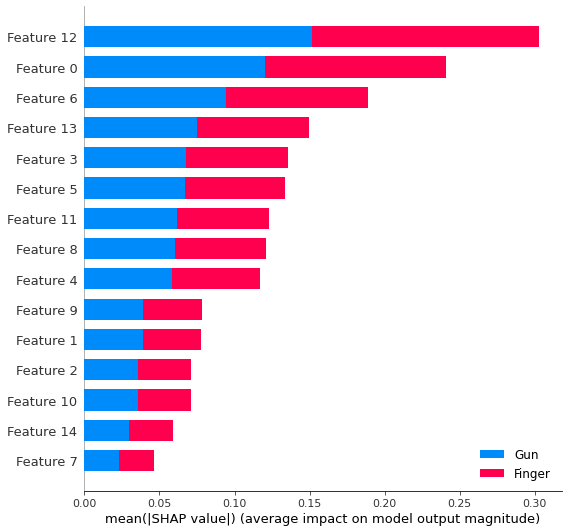

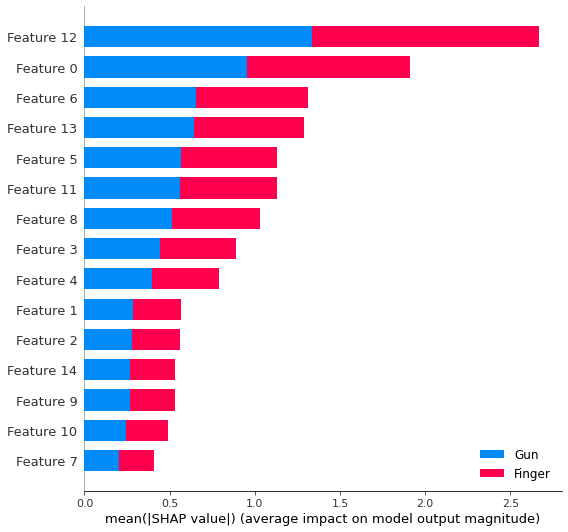

In [14]:
#For explanation obj
shap.summary_plot(list(explaination_obj.values.transpose(2,0,1)), dist_data, plot_type="bar", class_names= ["Gun","Finger"])
#For KernelExplainer (Its the same for my experiments)
#shap.summary_plot(shap_values, dist_data, plot_type="bar", class_names= ["Gun","Finger"])




#shap_values.base_values.shape
#dist_data.shape

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


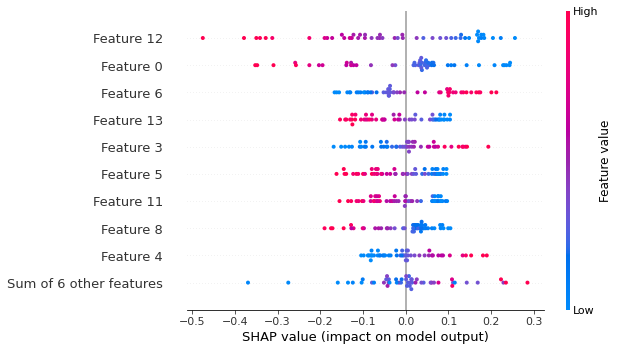

In [17]:
#for class 0
shp_val_0 =explaination_obj.values[:,:,0]
shp_bval_0 = explaination_obj.base_values[:,0]
shp_data_0 = explaination_obj.data
#print(shp_data_0.shape)
class0 = shap.Explanation(shp_val_0, base_values=shp_bval_0, data=explaination_obj.data)
#print(explaination_obj.values.shape,explaination_obj.values[:,:,0].shape)

shap.plots.beeswarm(class0)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


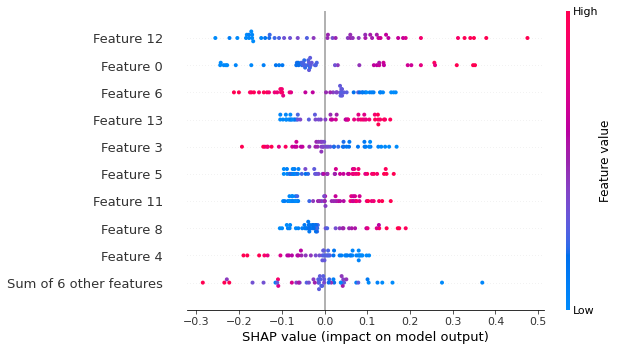

In [24]:
#for class 0
shp_val_1 =explaination_obj.values[:,:,1]
shp_bval_1 = explaination_obj.base_values[:,1]
#print(shp_data_0.shape)
class1 = shap.Explanation(shp_val_1, base_values=shp_bval_1, data=explaination_obj.data)
#print(explaination_obj.values.shape,explaination_obj.values[:,:,0].shape)

shap.plots.beeswarm(class1)

0


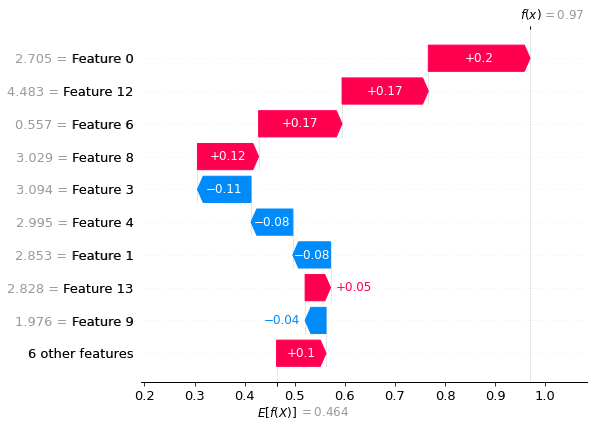

In [31]:
ts=36
print(int(y_test[ts]))
shap.plots.waterfall(class1[ts])#max_display=20) features to display
#0.783
#0.217


In [132]:
26/50


0.52

In [21]:
import pandas as pd
def find_ts_per_class(y_test, searched_class): 
    normal_sort = np.sort(y_test)
    arg_sort = np.argsort(y_test)
    class_x = arg_sort[np.where(normal_sort==searched_class)]
    return class_x

  
print(find_ts_per_class(y_train,1))

pd.DataFrame(dist_data).mean()

[47 45 37 44 38 39 34 36 40  0 31 28 25 23 19 17 16 14  8  7  6  5  4  1
 32 49]


0     1.581774
1     2.043688
2     1.849887
3     1.993394
4     1.573363
5     1.756312
6     2.738672
7     1.213414
8     1.822628
9     1.590006
10    3.403935
11    2.371110
12    3.236550
13    2.393954
14    2.779726
dtype: float32

In [113]:
#shap.summary_plot(shap_values_exp1, dist_data[:0], plot_type="bar", class_names= ["Gun","Finger"], feature_names = ["s1","s2","s3","s4","s5"])
ts = 48
outcome = int(y_test[ts])
print(outcome)
import pandas as pd
shap.initjs()
shap_values_exp1 = kernel_explainer.shap_values(dist_data[ts], nsamples=500)
#print(shap_values_exp1,y_test[35])
shap.force_plot(kernel_explainer.expected_value[outcome], shap_values_exp1[outcome], pd.DataFrame(dist_data[ts]).T)

0


In [114]:
def convert_to_prob(log_odd_prob, printt=True):
  prob = np.exp(log_odd_prob) / (1 + np.exp(log_odd_prob))
  check_prob = np.exp(-log_odd_prob) / (1 + np.exp(-log_odd_prob))
  add = prob+check_prob
  if printt : print(f"The probability for this class is {prob}, counter_prob is {check_prob}, and they add up to {add}")
  return prob

convert_to_prob(-1.61)

The probability for this class is 0.16658861357545965, counter_prob is 0.8334113864245404, and they add up to 1.0


0.16658861357545965

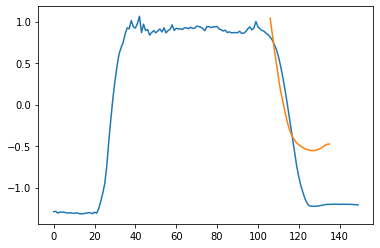

In [33]:
import matplotlib.pyplot as plt

shapelets_Lr=learning_shapelets_Lr.get_shapelets()
#print(y_train[31])
plot_ts_and_shapelet(X_train[36], shapelets_Lr[0])

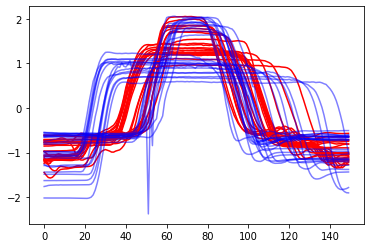

In [44]:
c0 = find_ts_per_class(y_train,0)
c1 = find_ts_per_class(y_train,1)

for i in c0: 
  plt.plot(X_train[i].T, color="red")

for i in c1: 
  plt.plot(X_train[i].T, color="blue",alpha=0.5)

In [ ]:
shap.initjs()


#print(pd.DataFrame(dist_data[35]).T)
#print(shap_values.)
shap.force_plot(explainer.expected_value, shap_values, pd.DataFrame(dist_data[35]).T)

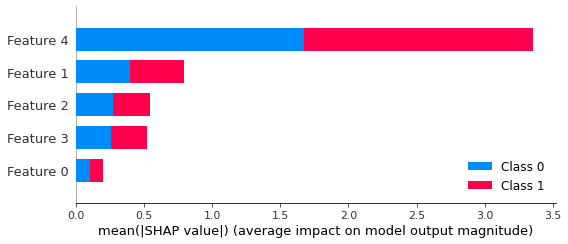

In [ ]:
shap.summary_plot(shap_values, dist_data)

In [ ]:
#exp = shap.Explanation(shap_values[:,:,2], shap_values.base_values[:,2], dist_data, feature_names=None)

IndexError: ignored

In [ ]:
shap.summary_plot(shap, X_test)

NameError: ignored

In [ ]:
shap.plots.waterfall(exp[0], max_display=14)

Exception: ignored

In [ ]:
dist_data = learning_shapelets_Lr.transform(X_train)
dist_data.shape
#np.cov(dist_data.T)

(50, 5)

In [ ]:
dist_data1 = learning_shapelets_Lr.transform(X_test)

In [ ]:
d_train = lgb.Dataset(dist_data, label=y_train)
d_test =  lgb.Dataset(dist_data1, label=y_test)

NameError: name 'dist_data' is not defined

TypeError: 'Dataset' object is not iterable

In [ ]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import shap

params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": False
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=10)

NameError: name 'd_train' is not defined

In [ ]:
model.predict(dist_data)

array([0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52,
       0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52,
       0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52,
       0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52, 0.52,
       0.52, 0.52, 0.52, 0.52, 0.52, 0.52])

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dist_data1)

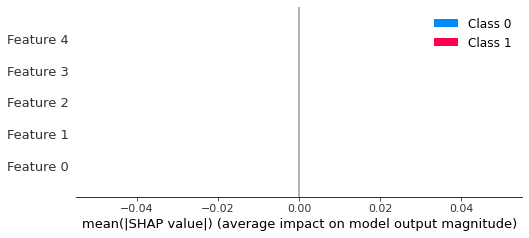

In [ ]:
shap.summary_plot(shap_values, dist_data)